In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.modeling import models, fitting

import decode as dc

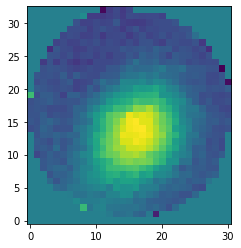

In [2]:
cont_fits = '../results/20171115052750/continuum_obs.fits'
data, header = fits.getdata(cont_fits, header=True)

plt.imshow(data, origin='lower')
plt.show()

In [3]:
X, Y = np.mgrid[0:data.shape[0], 0:data.shape[1]]
print(X)
print(Y)

[[ 0  0  0 ...  0  0  0]
 [ 1  1  1 ...  1  1  1]
 [ 2  2  2 ...  2  2  2]
 ...
 [30 30 30 ... 30 30 30]
 [31 31 31 ... 31 31 31]
 [32 32 32 ... 32 32 32]]
[[ 0  1  2 ... 28 29 30]
 [ 0  1  2 ... 28 29 30]
 [ 0  1  2 ... 28 29 30]
 ...
 [ 0  1  2 ... 28 29 30]
 [ 0  1  2 ... 28 29 30]
 [ 0  1  2 ... 28 29 30]]


In [58]:
g_init = models.Gaussian2D(
    amplitude=np.nanmax(data),
    x_mean=int(np.where(data == np.nanmax(data))[0]),
    y_mean=int(np.where(data == np.nanmax(data))[1])
) + models.Const2D(
    amplitude=-0.02
)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, X, Y, data)
error = np.diag(fit_g.fit_info["param_cov"]) ** 0.5

print(error)
print(g.param_names)
print(g.parameters)

[1.91266208e-02 6.13981722e-01 5.46837136e-01 6.63373628e-01
 8.50562445e-01 2.23994031e+05 4.30087598e-03]
('amplitude_0', 'x_mean_0', 'y_mean_0', 'x_stddev_0', 'y_stddev_0', 'theta_0', 'amplitude_1')
[ 1.42479510e-01  1.27889967e+01  1.59764133e+01  3.83542328e+00
  4.80284693e+00 -2.16792378e+09 -2.27804036e-02]


In [59]:
data_model = g(X, Y)
data_diff = data - g(X, Y)

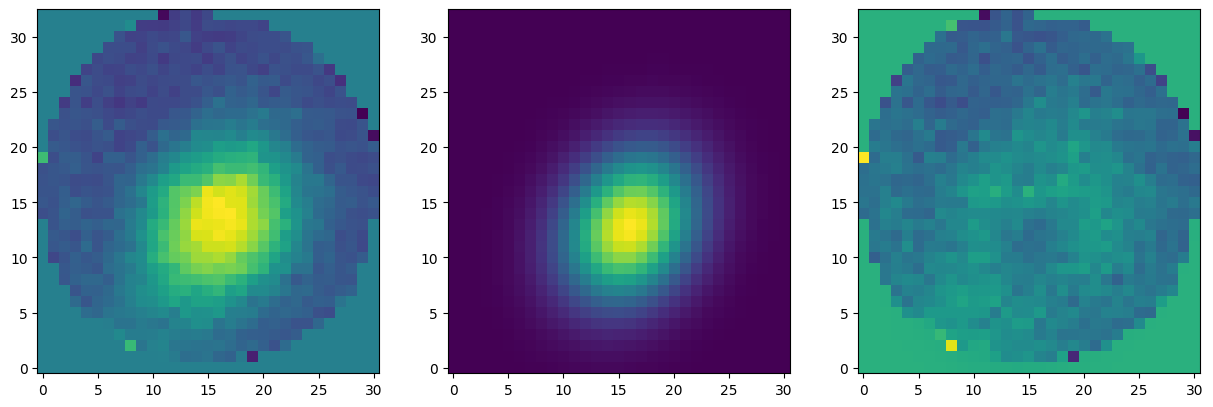

In [60]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=100)

ax[0].imshow(data, origin='lower')
ax[1].imshow(data_model, origin='lower')
ax[2].imshow(data_diff, origin='lower')

plt.show()

In [7]:
from lmfit import minimize, Parameters

In [68]:
params = Parameters()
params.add('amplitude', value=np.nanmax(data))
params.add('x_mean', value=int(np.where(data == np.nanmax(data))[0]))
params.add('y_mean', value=int(np.where(data == np.nanmax(data))[1]))
params.add('x_stddev', value=1.0)
params.add('y_stddev', value=1.0)
params.add('theta', value=0, min=0, max=2*np.pi)
params.add('noise', value=0)

In [32]:
def Gaussian2DandConst(x, y, amplitude, x_mean, y_mean, x_stddev, y_stddev, theta, noise):
    a = 0.5 * ((np.cos(theta) / x_stddev)**2 + (np.sin(theta) / y_stddev)**2)
    b = 0.5 * (np.sin(2*theta) / x_stddev**2 - np.sin(2*theta) / y_stddev**2)
    c = 0.5 * ((np.sin(theta) / x_stddev)**2 + (np.cos(theta) / y_stddev)**2)

    return amplitude * np.exp(-a * (x - x_mean)**2 - b * (x - x_mean) * (y - y_mean) - c * (y - y_mean)**2) + noise

In [33]:
def residual(params, x, y, data):
    amplitude = params['amplitude']
    x_mean = params['x_mean']
    y_mean = params['y_mean']
    x_stddev = params['x_stddev']
    y_stddev = params['y_stddev']
    theta = params['theta']
    noise = params['noise']

    return data - Gaussian2DandConst(x, y, amplitude, x_mean, y_mean, x_stddev, y_stddev, theta, noise)

In [69]:
out = minimize(residual, params, args=(X, Y, data))
out

In [70]:
best_fit = Gaussian2DandConst(X, Y, **out.params.valuesdict())

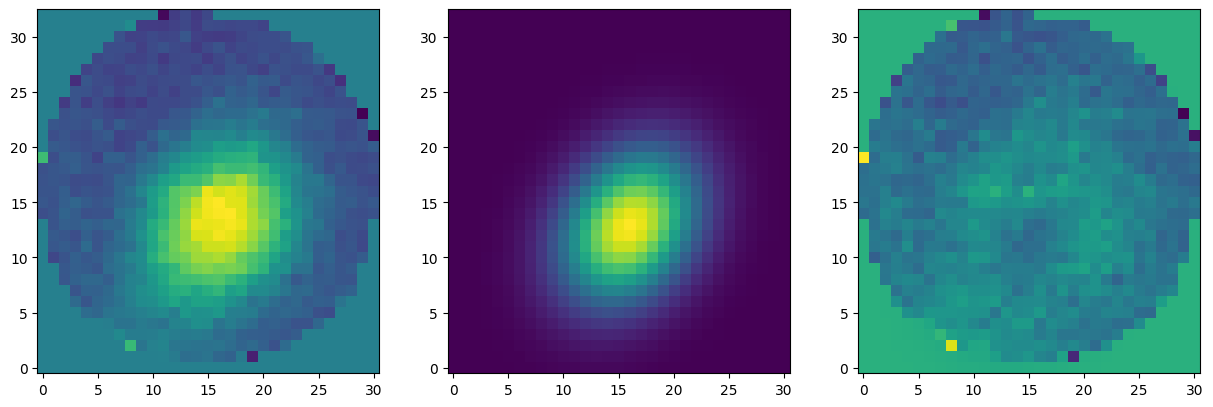

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=100)

ax[0].imshow(data, origin='lower')
ax[1].imshow(best_fit, origin='lower')
ax[2].imshow(data - best_fit, origin='lower')

plt.show()

In [87]:
out.params["x_stddev"] * header["CDELT1"] * 3600 * 2.35, out.params["y_stddev"] * header["CDELT2"] * 3600 * 2.35

(25.25173629824779, 19.07422519023584)